# Galaxy Selector MOC

**Compared to the "Simple Galaxy Selector, this works with Multi-Ordering-Sky-Maps**


***NOTE (this note may be wrong, just copied from old notebook)***: Before anything can happen, download the GW event localization map. Open the terminal and type:
"curl -O https://gracedb.ligo.org/api/superevents/sid/files/bayestar.fits,0"
with sid = superevent ID (could be incorporated into this notebook)

Select the galaxies to observe by WWFI in this simple manner:
- get the LIGO event data
- read the LIGO event data into the notebook, extract some information
- read the DESI database into the notebook, "clean" the data
- get the 90% credible regions for the event, add them as a column to the data
- only keep data within the 90% region
- calculate all the luminosities (& more)
- rank them by luminosity (for now just print the TARGETID), 3D/2D localization and with a luminosity-distance 2D dependant counterpart likelihood

Sources: 
- https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10
- https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html
- https://emfollow.docs.ligo.org/userguide/tutorial/multiorder_skymaps.html
- https://arxiv.org/pdf/1710.05452.pdf

## Import all libraries, load GW data and DESI data and extract basic info

### imports, GW data loading

In [1]:
import numpy as np
from scipy.stats import norm
import scipy as sc

from astropy.io import fits
from astropy.table import Table, hstack
from astropy import table

import healpy as hp
import astropy_healpix as ah

from astropy.table import QTable

import psycopg2

from astropy.cosmology import Planck18, z_at_value
from astropy.coordinates import Distance 
from astropy import units as u

import astropy.constants as asc

import matplotlib.pyplot as plt

Specifiy the path where the data is located and then load the data (this loads everything, just have a look)

In [2]:
path = "/global/homes/j/jgassert/ligo-desi-gw-follow-up/Galaxy Selection/Files/S200129mbayestar.multiorder.fits,1"
skymap = QTable.read(path)

skymap[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,1 / sr,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
1024,1.5324656455152846e-49,714.1819585125542,161.80898167011566,1.8648435769602432e-06
1025,5.385644463361342e-50,721.1167587942227,171.98003188197197,1.8195498736811365e-06
1026,1.507013849287337e-56,512.6497643516975,199.2304182183156,3.3061639172754294e-06
1027,9.15663190324263e-58,624.4690102361741,203.60306281109953,2.3179848195476794e-06
1028,1.0313363324845354e-49,674.1376225795897,201.22336091582892,2.0204049691069628e-06


### Get basic values from GW event

We now extract some basic information  from the healpix data:
- ipix_max: pixel with highest likelihood
- npix: total number of pixels
- ra, dec: ra and dec of the pixel with the highest likelihood

Then we open the full fits file and extract some more basic info from the header:
- dist_mean: mean distance of the GW event
- dist_std: error of the distance

In [57]:
# most probable sky location
i = np.argmax(skymap["PROBDENSITY"])
uniq = skymap[i]["UNIQ"]
print("UNIQ ID of highest prob sky localization: ", uniq)

UNIQ ID of highest prob sky localization:  29382844


In [59]:
# calculate the most probable pixel, convert to RA and dec
level_max, ipix_max = ah.uniq_to_level_ipix(uniq)
nside = ah.level_to_nside(level_max)
ra, dec = ah.healpix_to_lonlat(ipix_max, nside, order = "nested")
print("Highest probability at (RA, dec): ", ra.deg, dec.deg, "with prob [1/deg^2] of: ", skymap[i]['PROBDENSITY'].to_value(u.deg**-2), "and UNIQ ID: ", skymap[i]["UNIQ"])

Highest probability at (RA, dec):  318.33984375 4.574345562095717 with prob [1/deg^2] of:  0.07437342287566126 and UNIQ ID:  29382844


Now open the fits file and read basics info from the header

In [5]:
fits_gw = fits.open(path)
header = fits_gw[1].header
dist_mean = header["DISTMEAN"]
dist_std = header["DISTSTD"]
print("The dist_mean and dist_std values: ", dist_mean*u.Mpc, dist_std*u.Mpc)

The dist_mean and dist_std values:  908.4386811451134 Mpc 202.2234141038336 Mpc


In [6]:
# these values (924, 188Mpc) are close to z= 0.19, 0.03

### Get DESI data

Establish a connection to the DESI database and load the daily data.

In [7]:
try:
    db = psycopg2.connect(host='decatdb.lbl.gov', database='desidb', user='desi', password = "5kFibers!", port="5432")
    cursor = db.cursor()
except (Exception, psycopg2.Error) as error:
    print(error)

cursor = db.cursor()

In [8]:
redux = 'daily'
query = 'SELECT f.targetid,f.target_ra,f.target_dec,c.tileid,c.night,r.z,r.zerr,r.zwarn,r.deltachi2,f.flux_z,f.bgs_target,f.ebv, f.sersic, f.mws_target, c.filename\n' \
                    f'FROM {redux}.tiles_fibermap f\n' \
                    f'INNER JOIN {redux}.cumulative_tiles c ON f.cumultile_id=c.id\n' \
                    f'INNER JOIN {redux}.tiles_redshifts r ON r.cumultile_id=c.id AND r.targetid=f.targetid\n' \
                    f'WHERE q3c_radial_query( f.target_ra, f.target_dec, {ra.deg}, {dec.deg}, 50);'

cursor.execute(query)
rows = cursor.fetchall()

## Do all the calculations, selections,...

- turn the daily DESI data into a Table
- do some basic data selection stuff: only keep good + positive redshifts, only positive values of z-band flux and eliminate duplicates (right now simply takes the first entry)
- add the ipix (healpix) pixel value for each target
- calculate the probability for each target
- add these values to the Table ("PROB"), select only targets within the 90% credible region (i.e. with a certainty of 90% the GW event is inside this region)
- calculate the distances and its errors from the redshift, add to the data table
- calculate the 3D probability just like here: https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10 (§4) and add these values to the table
- sort the table by its 3D probability (descending)
- calculate absolute and apparent magnitude, luminosity and add to table

The final step is to include the calculation of the most likely host galaxy from https://arxiv.org/pdf/1710.05452.pdf (GW170817); these values are then also added to the table as "P_GAL"

### Create DESI data Table and data clean up

In [9]:
if rows:
    data = Table(list(map(list, zip(*rows))),
                             names=['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'TILEID', 'NIGHT', 'Z', 'ZERR', 'ZWARN', 'DELTACHI2', 'FLUX_Z', 'BGS_TARGET', 'EBV', 'SERSIC', 'MWS_TARGET','FILENAME'])
data[:5:-1] 

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FLUX_Z,BGS_TARGET,EBV,SERSIC,MWS_TARGET,FILENAME
int64,float64,float64,int64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,str71
2305843024288149014,288.437125408824,25.7673558069454,40350,20230511,2.41192312663584e-05,5.74052093931137e-07,0,275787.713730946,-99.0,0,0.440804988145828,0.0,1152921504606846976,daily/tiles/cumulative/40350/20230511/redrock-9-40350-thru20230511.fits
2305843024288332221,288.42563904523,25.6421082666076,40350,20230511,-0.000347841386023699,1.67023387315074e-06,0,76657.2971824054,-99.0,0,0.559371054172516,0.0,1152921504606846976,daily/tiles/cumulative/40350/20230511/redrock-9-40350-thru20230511.fits
2305843024292905381,288.642800456176,25.8505926807117,40350,20230511,-4.41892038965445e-05,1.33330003474229e-06,0,47018.0845161545,-99.0,0,0.516548931598663,0.0,1152921504606846976,daily/tiles/cumulative/40350/20230511/redrock-9-40350-thru20230511.fits
-403509002,287.858501295119,26.3734778482201,40350,20230511,1.53259776377859,0.000104774843987268,1,49.7287774682045,0.0,0,0.337243884801865,0.0,0,daily/tiles/cumulative/40350/20230511/redrock-9-40350-thru20230511.fits
2305843024380479782,287.969593143161,26.1570031375444,40350,20230511,1.1168489114782e-05,8.92050886784167e-07,0,113363.472911358,-99.0,0,0.341475278139114,0.0,1152921504606846976,daily/tiles/cumulative/40350/20230511/redrock-9-40350-thru20230511.fits
2305843024288492892,288.703429502793,25.195925797038,40350,20230511,2.39565422280094e-05,6.29740692210237e-07,0,111983.268348011,-99.0,0,0.527522325515747,0.0,1152921504606846976,daily/tiles/cumulative/40350/20230511/redrock-9-40350-thru20230511.fits
2305843024292849606,288.883592696404,25.7189372897126,40350,20230511,3.82437224561248e-05,8.68148465274979e-07,0,132800.083839793,-99.0,0,0.578824400901794,0.0,1152921504606846976,daily/tiles/cumulative/40350/20230511/redrock-9-40350-thru20230511.fits
2305843024288437775,288.322571928291,25.255055122181,40350,20230511,-1.07467856394854e-05,9.9212810351001e-07,0,114249.979680069,-99.0,0,0.597545385360718,0.0,1152921504606846976,daily/tiles/cumulative/40350/20230511/redrock-9-40350-thru20230511.fits
2305843024288343102,288.326104056761,25.3322437260209,40350,20230511,4.43215570436056e-06,5.28676074675685e-07,0,415219.770513907,-99.0,0,0.585721611976624,0.0,1152921504606846976,daily/tiles/cumulative/40350/20230511/redrock-9-40350-thru20230511.fits


In [10]:
data = data[data['ZWARN']==0]
data = data[data['Z']>=0]
data = data[data['FLUX_Z']>0]
data = table.unique(data, keys = "TARGETID")

In [11]:
print(f"We have {len(data)} objects in the full catalog") 

We have 3135207 objects in the full catalog


### Calculate the healpix id for every object in the catalog and its probability; append this data to the Table

In [12]:
max_level = 29 # highest possible HEALPix resolution that can be represented in a 64-bit signed integer
max_nside = ah.level_to_nside(max_level)
level, ipix = ah.uniq_to_level_ipix(skymap["UNIQ"])

index = ipix*(2**(max_level-level))**2

sorter = np.argsort(index)

# this is the NESTED pixel index of the target sky location, NOT THE UNIQ ID
match_ipix = ah.lonlat_to_healpix(data["TARGET_RA"]*u.deg, data["TARGET_DEC"]*u.deg, max_nside, order='nested')

# here we get the pixel index (i.e. where the entry is in the table, also NOT THE UNIQ ID) of each target
sorter_i = sorter[np.searchsorted(index, match_ipix, side='right', sorter=sorter) - 1]
probs = skymap[sorter_i]['PROBDENSITY'].to_value(u.deg**-2)

# now we calculate the UNIQ ID for all our targets:

UNIQ = skymap["UNIQ"][sorter_i]

In [13]:
# len(UNIQ), len(data), len(skymap)

In [14]:
#data = data.keep_columns(["TARGETID", "TARGET_RA", "TARGET_DEC", "TILEID", "NIGHT", "Z", "ZERR", "ZWARN", "DELTACHI2", "FLUX_Z", "BGS_TARGET", "EBV", "SERSIC", "MWS_TARGET", "FILENAME"])
                          

In [15]:
data = hstack([data, Table({"UNIQ": UNIQ}), Table({"PROBDENSITY": probs})])

In [16]:
data[:5]

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FLUX_Z,BGS_TARGET,EBV,SERSIC,MWS_TARGET,FILENAME,UNIQ,PROBDENSITY
int64,float64,float64,int64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,str71,int64,float64
39627426287845435,2.44719240020798,-14.8784810461915,4681,20211031,1.29487677591325,7.8087057171638e-05,0,180.558159992099,1.67646908760071,0,0.0271596927195787,0.0,0,daily/tiles/cumulative/4681/20211031/redrock-1-4681-thru20211031.fits,8388,1.8834870356564702e-38
39627426287845517,2.50471862202463,-14.8968566192167,4681,20211031,0.790131691198744,2.30243720492388e-05,0,461.392431020737,1.8420695066452,0,0.0275762490928173,0.0,0,daily/tiles/cumulative/4681/20211031/redrock-1-4681-thru20211031.fits,8388,1.8834870356564702e-38
39627426287845557,2.52321094106128,-14.9079968190469,4681,20211031,1.30947827895762,0.000110767434416278,0,26.432828810066,1.12536370754242,0,0.0276389718055725,1.0,0,daily/tiles/cumulative/4681/20211031/redrock-1-4681-thru20211031.fits,8388,1.8834870356564702e-38
39627426287845626,2.56200118260528,-14.8842963635124,4681,20211031,0.284550072861601,1.7577289604241e-05,0,180.535153388977,1.13342213630676,0,0.0275229904800653,0.0,0,daily/tiles/cumulative/4681/20211031/redrock-1-4681-thru20211031.fits,8388,1.8834870356564702e-38
39627426292039772,2.62606258092301,-14.8780864557311,4681,20211031,0.189790746031762,1.28616026055591e-05,0,41.7928801327944,0.959446787834167,0,0.0275655761361122,0.0,0,daily/tiles/cumulative/4681/20211031/redrock-1-4681-thru20211031.fits,8388,1.8834870356564702e-38


In [17]:
print(f"The highest and lowest probability values in our catalog are: {np.min(probs)} and {np.max(probs)}")

The highest and lowest probability values in our catalog are: 8.612931378658332e-76 and 0.07437342287566126


### Sort the skymap table and get 90% credible region

In [18]:
# copy the table
skymap_sort = Table(skymap, copy = True)

In [19]:
# check whether copy worked:
# skymap_sort, skymap
# np.max(skymap["UNIQ"])

In [20]:
# now sort the skymap by its probability (descending)
skymap_sort.sort('PROBDENSITY', reverse=True)

In [21]:
# this shows the first entries sorted be their probability
skymap_sort[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,1 / sr,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
29382844,244.15354488832944,905.4875407192519,168.42603182511863,1.178862966456941e-06
29382833,244.15069570725393,906.3599020620863,168.32227138877792,1.1767188633863131e-06
29382838,244.14297432946807,905.785362123571,168.39084745511798,1.1781302276595755e-06
29382847,244.11738026796397,904.9078983771989,168.49631024409334,1.1802901306190855e-06
29382835,244.07881873987986,906.0618018858346,168.35749619647882,1.1774510097184074e-06


In [53]:
# now get 90% credible region area

level, ipix = ah.uniq_to_level_ipix(skymap_sort['UNIQ'])
pixel_area = ah.nside_to_pixel_area(ah.level_to_nside(level)) # this is the area each pixel contains

# calculate the probability per pixel (careful: since the pixels differ in size, this is not neceseraliy a useful quantity
prob = pixel_area * skymap_sort['PROBDENSITY']

# calc cumsum of probabilities and get index of pixel that sums up to 0.9
cumprob = np.cumsum(prob)
i = cumprob.searchsorted(0.9)

# print area
area_90 = pixel_area[:i].sum()
area_90.to_value(u.deg**2)

53.032867206780615

### can be deleted, just tried things out

In [60]:
skymap_sort = hstack([skymap_sort, Table({"PROB": prob})])

In [54]:
np.max(prob)

<Quantity 0.00022682>

In [61]:
skymap_sort[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,PROB
,1 / sr,Mpc,Mpc,1 / Mpc2,
int64,float64,float64,float64,float64,float64
29382844,244.15354488832944,905.4875407192519,168.42603182511863,1.178862966456941e-06,6.09581456954544e-05
29382833,244.15069570725393,906.3599020620863,168.32227138877792,1.1767188633863131e-06,6.0957434336562626e-05
29382838,244.14297432946807,905.785362123571,168.39084745511798,1.1781302276595755e-06,6.095550652973003e-05
29382847,244.11738026796397,904.9078983771989,168.49631024409334,1.1802901306190855e-06,6.0949116425786135e-05
29382835,244.07881873987986,906.0618018858346,168.35749619647882,1.1774510097184074e-06,6.0939488716926676e-05


In [62]:
skymap_prob = Table(skymap_sort, copy = True)

In [64]:
skymap_prob.sort("PROB", reverse = True)

In [65]:
skymap_prob[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,PROB
,1 / sr,Mpc,Mpc,1 / Mpc2,
int64,float64,float64,float64,float64,float64
7344494,227.11872204879973,917.2444113491661,168.0419597839432,1.149986519956959e-06,0.00022682015377083184
7347417,227.06118055964373,885.8238105385814,171.752754645542,1.2282253579061448e-06,0.0002267626879252123
7344965,227.0062357278737,913.5162880494381,167.67633785878303,1.1592491070437897e-06,0.00022670781532343573
7344614,227.00424753929823,915.343886171108,167.63138228341072,1.1547948041355468e-06,0.0002267058297485155
7347420,227.0041792333663,885.422995167548,171.7402407754239,1.2293037638565399e-06,0.00022670576153237793


### Compare Tables, only leave 90% credible region in DESI data table

Now we can get a Table that only contains the 90% credible region. From there we only leave the matching objects in the DESI data

In [23]:
# we simply select only the entries that are within the 90% credible region
skymap_90 = skymap_sort[:i]

In [ ]:
# check = [val.to_value(u.deg**-2) for val in skymap_90["PROBDENSITY"]]

In [25]:
print("This is the number of UNIQ ID of objects which should lie within the 90% credible region (NOT THE NUMBER OF OBJECTS, as there can be multiple objects per UNIQ ID):", len(np.intersect1d(skymap_90["UNIQ"], data["UNIQ"])))

This is the number of UNIQ ID of objects which should lie within the 90% credible region (NOT THE NUMBER OF OBJECTS, as there can be multiple objects per UNIQ ID): 7251


In [26]:
mask = np.in1d(data["UNIQ"], skymap_90["UNIQ"])

In [27]:
len(mask), len(mask == True), mask[:5], np.min(mask), np.max(mask)

(3135207, 3135207, array([False, False, False, False, False]), False, True)

In [28]:
data_90 = data[mask]

In [29]:
len(data_90)

80722

In [30]:
print("Check if the region from where the galaxies have been selected makes any sense (RA; DEC): ", np.min(data_90["TARGET_RA"]), np.max(data_90["TARGET_RA"]), np.min(data_90["TARGET_DEC"]), np.max(data_90["TARGET_DEC"]))

Check if the region from where the galaxies have been selected makes any sense (RA; DEC):  315.032699910502 320.968224603758 -1.33087910597711 14.1114593957212


In [31]:
np.max(data_90["PROBDENSITY"])

0.07437342287566126

In [43]:
data_90.sort('PROBDENSITY', reverse=True)

In [45]:
data_90[:2]

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FLUX_Z,BGS_TARGET,EBV,SERSIC,MWS_TARGET,FILENAME,UNIQ,PROBDENSITY
int64,float64,float64,int64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,str71,int64,float64
39627898725865034,318.341830044524,4.57322111244074,22388,20220530,0.265580972154904,1.64955354543276e-05,0,70.9080293998122,69.1650161743164,131074,0.112329810857773,1.13607883453369,0,daily/tiles/cumulative/22388/20220530/redrock-5-22388-thru20220530.fits,29382844,0.07437342287566126
39627898725865459,318.35988431132,4.53173120893407,9624,20220611,0.982156081823739,4.93303942864255e-05,0,115.738883554935,0.995873689651489,0,0.105607852339745,1.0,0,daily/tiles/cumulative/9624/20220611/redrock-4-9624-thru20220611.fits,29382833,0.07437255496547353


In [69]:
print("We have now performed all the necessary steps to get the localization selection in 2D, i.e. the angle on the sky")
min_z = np.min(data_90["Z"])
max_z = np.max(data_90["Z"])
print(f"However, we have not used the distance data at all. Therefore our redhsifts range from {min_z} to {max_z}")

We have now performed all the necessary steps to get the localization selection in 2D, i.e. the angle on the sky
However, we have not used the distance data at all. Therefore our redhsifts range from 2.57495916197917e-08 to 5.55588409874102


### Calculate all the distances of the objects from the redshifts

In [78]:
distances = Distance(z=data_90["Z"], cosmology=Planck18)
distances_err = Distance(z=data_90["ZERR"], cosmology=Planck18)

data_90 = hstack([data_90, Table({"DIST": distances}), Table({"DIST_ERR": distances_err})])

In [79]:
data_90[:5]

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FLUX_Z,BGS_TARGET,EBV,SERSIC,MWS_TARGET,FILENAME,UNIQ,PROBDENSITY,DIST,DIST_ERR
,,,,,,,,,,,,,,,,,Mpc,Mpc
int64,float64,float64,int64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,str71,int64,float64,float64,float64
39627898725865034,318.341830044524,4.57322111244074,22388,20220530,0.265580972154904,1.64955354543276e-05,0,70.9080293998122,69.1650161743164,131074,0.112329810857773,1.13607883453369,0,daily/tiles/cumulative/22388/20220530/redrock-5-22388-thru20220530.fits,29382844,0.07437342287566126,1393.709064995035,0.07309044717122476
39627898725865459,318.35988431132,4.53173120893407,9624,20220611,0.982156081823739,4.93303942864255e-05,0,115.738883554935,0.995873689651489,0,0.105607852339745,1.0,0,daily/tiles/cumulative/9624/20220611/redrock-4-9624-thru20220611.fits,29382833,0.07437255496547353,6642.314130103612,0.21858467963945125
39627898725865283,318.352856381538,4.51929401195848,6551,20220606,0.818332646738268,4.60537894095151e-05,0,78.4640438482165,0.840378820896149,0,0.104418501257896,0.0,0,daily/tiles/cumulative/6551/20220606/redrock-9-6551-thru20220606.fits,29382833,0.07437255496547353,5307.569750224303,0.2040654177885191
39627898725865383,318.357101734049,4.5156744518565,23974,20220601,0.0626446011077805,4.91603558902857e-06,0,2472.10256794095,271.315856933594,131074,0.103391066193581,0.674608528614044,0,daily/tiles/cumulative/23974/20220601/redrock-7-23974-thru20220601.fits,29382833,0.07437255496547353,290.596138689868,0.021782381719236157
39627898725865711,318.367092687767,4.56975983518192,6551,20220609,0.901943609669016,5.25564168758817e-05,0,97.5929107367992,1.28755128383636,0,0.109757766127586,0.0,0,daily/tiles/cumulative/6551/20220609/redrock-9-6551-thru20220609.fits,29382838,0.0743702028992952,5981.130570715325,0.23287987296867702


### Lets check how much the distance measurement changes in the 90% credible region of LIGO and compare to our DESI data

We should see a lot more data in DESI (since we haven't done any redshift selection and there can be multiple objects per GW-pixel). Be carfeul, we are comparing actual object counts with the number of pixels.


We still see, that most of the GW localization is roughly between 780Mpc and 950Mpc. DESI definitely has a most of its data in this range as well.

Our distance ranges from 443.46970862827453 Mpc to 949.3641839334775 Mpc
Let's visualize the distance distribution of the LIGO event in the 90% credible region


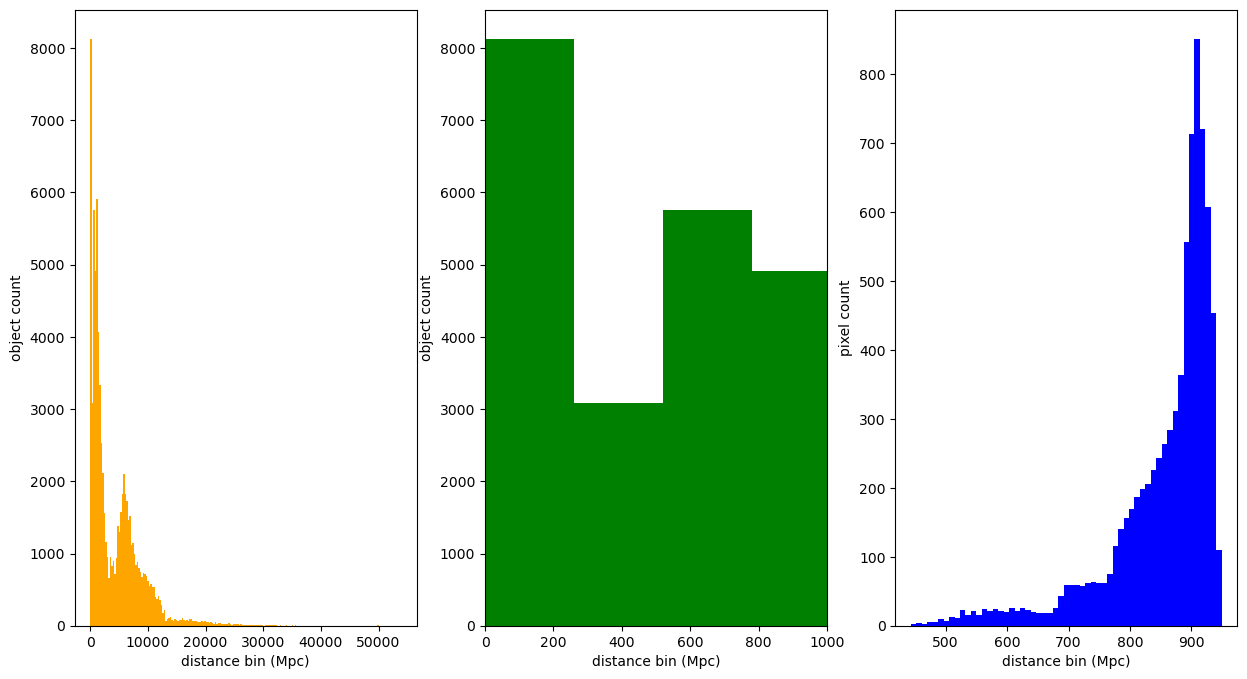

In [96]:
dist_max_90 = np.max(skymap_90["DISTMU"])*u.Mpc
dist_min_90 = np.min(skymap_90["DISTMU"])*u.Mpc
print(f"Our distance ranges from {dist_min_90} to {dist_max_90}")
print("Let's visualize the distance distribution of the LIGO event in the 90% credible region")

fig, ax = plt.subplots(ncols = 3, figsize = (15,8))


ax[0].hist(data_90["DIST"], bins = "auto", color = "orange")
ax[1].hist(data_90["DIST"], bins = "auto", color = "green")
ax[2].hist(skymap_90["DISTMU"], bins = "auto", color = "blue")


for axis in ax:
    axis.set_xlabel("distance bin (Mpc)")

ax[0].set_ylabel("object count")
ax[1].set_ylabel("object count")
ax[2].set_ylabel("pixel count")

ax[1].set_xlim(0,1000)
    
plt.show()

In [97]:
len(skymap_90), len(data_90)

(7923, 80722)

### To reduce our data even more, lets cut out the unreasonably far away objects

We simply take maximum and minimum distance we get from the LIGO skymap (i.e. DISTMU+-DISTERR) and check, whether every galaxy in that pixel falls inside this range.